<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
# reading in the file
import pandas as pd
import zipfile

zf = zipfile.ZipFile('../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip') 
df = pd.read_csv(zf.open('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'))

df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [2]:
df.shape

(28332, 24)

In [3]:
""" PREPROCESSING & TOKENIZING """
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

STOPWORDS = set(STOPWORDS).union(set(['thisisatest', 'fakestopwordhere']))

def tokenize(doc):
    """ Takes a doc and returns the tokens using gensim utilities """
    return [token for token in simple_preprocess(doc) if token not in STOPWORDS]

df['tokens'] = [tokenize(doc) for doc in df['reviews.text']]

In [4]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,tokens
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, item, bad, quality, missing, backup, s..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, products, like]"


In [5]:
""" FIT A GENSIM LDA TOP MODEL """

# A Dictionary Representation of all the words in our corpus
# This is analogous to fitting a model with our tokens
# takes a list of docs and their listed tokens and builds a dictionary of id's and words
id2word = corpora.Dictionary(df['tokens'])
id2word.token2id['car']

777

In [6]:
# Gets the "bag of words" of the id2word dictionary.
id2word.doc2bow(tokenize("test apple giant huge far"))

[(205, 1), (434, 1), (1193, 1), (1875, 1), (2518, 1)]

In [7]:
import sys
print(sys.getsizeof(id2word))

56


In [8]:
len(id2word.keys())

9621

In [9]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [10]:
len(id2word.keys())

3581

In [11]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(doc) for doc in df['tokens']]

In [12]:
corpus[345][:10]

[(17, 1), (18, 1), (21, 1), (34, 1)]

In [13]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 20,
                   passes=3,
                   workers=12
                  )

In [14]:
# Import regular expressions
import re
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [15]:
topics = [' '.join(t[0:5]) for t in words]

In [16]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
great kindle tablet screen price

------ Topic 1 ------
good great tablet games old

------ Topic 2 ------
good batteries price great quality

------ Topic 3 ------
tablet great love use old

------ Topic 4 ------
great price batteries long tablet

------ Topic 5 ------
tablet great amazon good product

------ Topic 6 ------
buy good amazon love batteries

------ Topic 7 ------
batteries good love works kids

------ Topic 8 ------
great games perfect tablet use

------ Topic 9 ------
great batteries price buy amazon

------ Topic 10 ------
tablet easy use amazon good

------ Topic 11 ------
work good price great like

------ Topic 12 ------
bought loves easy use gift

------ Topic 13 ------
tablet great kindle bought amazon

------ Topic 14 ------
great tablet use kindle screen

------ Topic 15 ------
tablet loves kids great old

------ Topic 16 ------
batteries amazon use good better

------ Topic 17 ------
great tablet batteries bought apps

------ Topic 18 ----

In [17]:
""" SELECTION OF MOST APPROPRIATE TOPICS USING COHERENCE VALUES """
distro = [lda[d] for d in corpus]
num_topics = 20

def update(doc):
        d_dist = {k:0 for k in range(0,num_topics)}
        for topic in doc:
            # Topic is Tuple where the first part is the topic id
            # the second part is the topic distribution in that doc
            d_dist[topic[0]] = topic[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [18]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.107218 -0.021017       1        1  14.267330
4     -0.104870  0.017350       2        1   7.250144
15     0.104799 -0.008567       3        1   7.184131
3      0.087471  0.016498       4        1   6.745695
14     0.005476  0.065063       5        1   6.739215
2     -0.085117 -0.009420       6        1   5.418731
10     0.048355  0.038953       7        1   4.859179
12     0.111716 -0.072346       8        1   4.744186
0     -0.003942  0.045517       9        1   4.488961
5     -0.012456  0.027452      10        1   4.284953
11    -0.082933 -0.010821      11        1   4.174748
9     -0.102821 -0.005983      12        1   4.029592
18     0.106490 -0.001000      13        1   3.918777
19    -0.005544  0.051038      14        1   3.735106
17    -0.001766  0.000118      15        1   3.355410
6     -0.032936  0.001434      16        1   3.323963
13     0.042670  0.064224      17        1   3.290359
1      0.046358 -0.044960      18        1   3.003534
8      0.041544 -0.058211      19        1   2.685968
7     -0.055276 -0.095321      20        1   2.500024, topic_info=           Term         Freq        Total Category  logprob  loglift
18    batteries  6545.000000  6545.000000  Default  30.0000  30.0000
21        great  8820.000000  8820.000000  Default  29.0000  29.0000
2432     tablet  7328.000000  7328.000000  Default  28.0000  28.0000
34         good  5235.000000  5235.000000  Default  27.0000  27.0000
17        price  4846.000000  4846.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
9          work    48.492790  1863.013672  Topic20  -5.0661   0.0403
2075     kindle    54.583088  3241.270752  Topic20  -4.9478  -0.3951
24       amazon    54.688866  3752.384766  Topic20  -4.9458  -0.5396
885        gift    40.935177  1203.521484  Topic20  -5.2355   0.3079
21        great    46.297432  8820.387695  Topic20  -5.1124  -1.5609

[1578 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
56        1  0.638584    aa
56        2  0.069460    aa
56        4  0.004481    aa
56        5  0.006722    aa
56        6  0.042572    aa
...     ...       ...   ...
3580      1  0.087027  äôve
3580      3  0.087027  äôve
3580      5  0.087027  äôve
3580      8  0.609188  äôve
3580     18  0.087027  äôve

[8525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 5, 16, 4, 15, 3, 11, 13, 1, 6, 12, 10, 19, 20, 18, 7, 14, 2, 9, 8])

In [19]:
topics = pd.DataFrame.from_records(new_distro)
topics.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.376311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541843,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.841648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.762490,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.841665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.841666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
df['primaryTopic'] = topics.idxmax(axis=1)

In [21]:
df[['primaryTopic', 'reviews.rating']].groupby('primaryTopic').mean()

,reviews.rating
primaryTopic,
0,4.613345
1,4.534483
2,4.559006
3,4.681200
4,4.650522
5,4.433185
6,4.511820
7,4.331409
8,4.596266


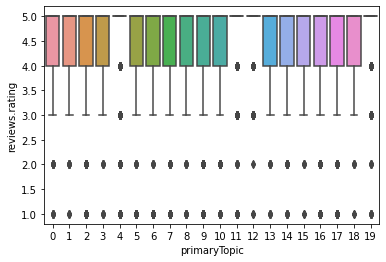

In [22]:
import seaborn as sns

ax = sns.boxplot(x="primaryTopic", y="reviews.rating",
                 data=df)

In [23]:
df['reviews.numHelpful'].describe()

count    16115.000000
mean         0.529321
std          9.345017
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        621.000000
Name: reviews.numHelpful, dtype: float64

In [24]:
topics_df = pd.DataFrame.from_records(new_distro)
topics_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.376311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541843,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.841648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.762490,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.841665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.841666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
""" VISUALIZING TOPICS """

# Reading elements of statistical learning. Will finish this tonight after/during afterhours.

' VISUALIZING TOPICS '

In [26]:
""" FINDINGS """


' FINDINGS '

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling